In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_9770/1521273946.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Load the dataset
columns = [
    'Family Name',
    'Variation',
    'Algorithm Name',
    'Year',
    'Looked at?',
    'Relevant?',
    'Parallel?',
    'Quantum?',
    'Time Complexity Class',
    'Approximation Factor Class (Mult)',
    'Approximation Factor Class (Add)',
    'Approximation Type (additive/multiplicative)',
    'Parametrized Approximation?',
    'Type of PTAS (if PTAS)',
    'Parametrized Approximation?'
]
approximation_algorithms = pd.read_csv(
    'approximation_algorithms.csv', usecols=columns)

# Clean and prepare the data
approximation_algorithms['Year'] = pd.to_numeric(
    approximation_algorithms['Year'].str.extract(r'(\d{4})')[0], errors='coerce')
approximation_algorithms.dropna(subset=['Year'], inplace=True)
approximation_algorithms['Year'] = approximation_algorithms['Year'].astype(int)

# Filter out irrelevant data
approximation_algorithms = approximation_algorithms[approximation_algorithms['Relevant?'] != '0']
approximation_algorithms = approximation_algorithms[approximation_algorithms['Relevant?'] != 0]

# # Filter out 0.001 looked at
approximation_algorithms = approximation_algorithms[approximation_algorithms['Looked at?'] != '0.001']
approximation_algorithms = approximation_algorithms[approximation_algorithms['Looked at?'] != '0']

# # Filter out Parallel algorithms
approximation_algorithms = approximation_algorithms[approximation_algorithms['Parallel?'] != '1']

# # Filter out Quantum algorithms
approximation_algorithms = approximation_algorithms[approximation_algorithms['Quantum?'] != '1']
approximation_algorithms = approximation_algorithms[approximation_algorithms['Quantum?'] != 1]

# if Type of PTAS (if PTAS) is  NaN and Parametrized Approximation? contains yes or yes?, then it is a "parameterized, non-PTAS" algorithm
approximation_algorithms.loc[approximation_algorithms['Type of PTAS (if PTAS)'].isna() & approximation_algorithms['Parametrized Approximation?'].str.contains(
    'yes', case=False, na=False), 'Type of PTAS (if PTAS)'] = 'parameterized, non-PTAS'

# if Type of PTAS (if PTAS) is  NaN and Parametrized Approximation? contains no or no?, then it is a "non-parameterized" algorithm
approximation_algorithms.loc[approximation_algorithms['Type of PTAS (if PTAS)'].isna() & approximation_algorithms['Parametrized Approximation?'].str.contains(
    'no', case=False, na=False), 'Type of PTAS (if PTAS)'] = 'non-parameterized'

# remove question mark from Type of PTAS (if PTAS)
approximation_algorithms['Type of PTAS (if PTAS)'] = approximation_algorithms['Type of PTAS (if PTAS)'].str.replace(
    '?', '')


# Sort rows
approximation_algorithms.sort_values(
    by=['Family Name', 'Variation', 'Year'], inplace=True)



In [3]:
# merge all ptas types different from non-parameterized and parameterized, non-PTAS, into "arbitrarily small parameterized error"
approximation_algorithms.loc[~approximation_algorithms['Type of PTAS (if PTAS)'].isin(
    ['non-parameterized', 'parameterized, non-PTAS']), 'Type of PTAS (if PTAS)'] = 'arbitrarily small parameterized error'

# if approximation factor class (add) is 1.99 ant approximation type contains "additive", than Type of PTAS (if PTAS) is "arbitrarily small parameterized error"
approximation_algorithms.loc[(approximation_algorithms['Approximation Factor Class (Add)'] == 1.99) & approximation_algorithms['Approximation Type (additive/multiplicative)'].str.contains(
    'additive', case=False, na=False), 'Type of PTAS (if PTAS)'] = 'arbitrarily small parameterized error'


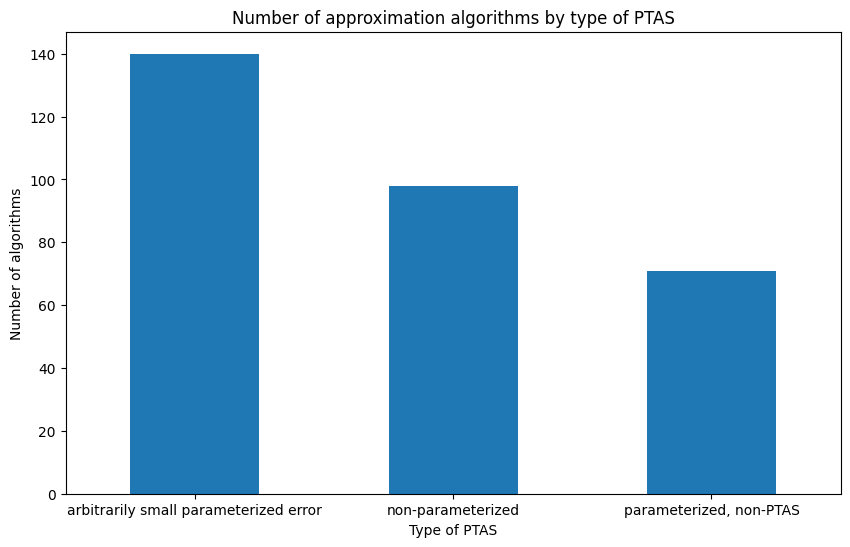

In [4]:
data = approximation_algorithms.copy()

# plot
fig, ax = plt.subplots(figsize=(10, 6))
data.groupby('Type of PTAS (if PTAS)').size().plot(kind='bar', ax=ax)

# rotate x labels
plt.xticks(rotation=0)

plt.xlabel('Type of PTAS')
plt.ylabel('Number of algorithms')
plt.title('Number of approximation algorithms by type of PTAS')
plt.show()

/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_9770/1725059946.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby('Type of PTAS (if PTAS)').size().plot(kind='pie', autopct='%1.1f%%', ax=ax, labels=None)


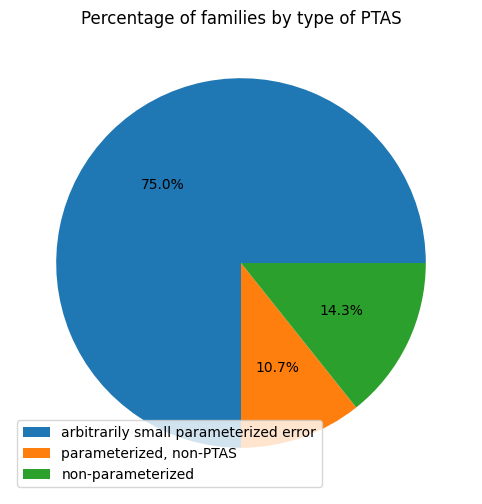

In [5]:
data = approximation_algorithms.copy()

# group by family, if at least one algorithm in the family is arbitrary small parameterized error, then the family is arbitrary small parameterized error
# if at least one algorithm in the family is parameterized, non-PTAS, then the family is parameterized, non-PTAS
# if at least one algorithm in the family is non-parameterized, then the family is non-parameterized

data['Type of PTAS (if PTAS)'] = data.groupby('Family Name')['Type of PTAS (if PTAS)'].transform(
    lambda x: 'arbitrarily small parameterized error' if 'arbitrarily small parameterized error' in x.values else (
        'parameterized, non-PTAS' if 'parameterized, non-PTAS' in x.values else 'non-parameterized')
)

data = data.drop_duplicates(subset=['Family Name', 'Type of PTAS (if PTAS)'])

# follow the order arbitrarily small parameterized error, parameterized, non-PTAS, non-parameterized
data['Type of PTAS (if PTAS)'] = pd.Categorical(
    data['Type of PTAS (if PTAS)'], categories=['arbitrarily small parameterized error', 'parameterized, non-PTAS', 'non-parameterized'], ordered=True)

# sort by type of PTAS
data.sort_values(by='Type of PTAS (if PTAS)', inplace=True)



# plot percentage of families by type of PTAS
fig, ax = plt.subplots(figsize=(10, 6))
data.groupby('Type of PTAS (if PTAS)').size().plot(kind='pie', autopct='%1.1f%%', ax=ax, labels=None)

ax.legend(loc=3, labels=data['Type of PTAS (if PTAS)'].unique())





plt.title('Percentage of families by type of PTAS')
plt.show()

/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_9770/2851028208.py:24: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage = data.groupby('Type of PTAS (if PTAS)').size() / data['Family Name'].nunique() * 100


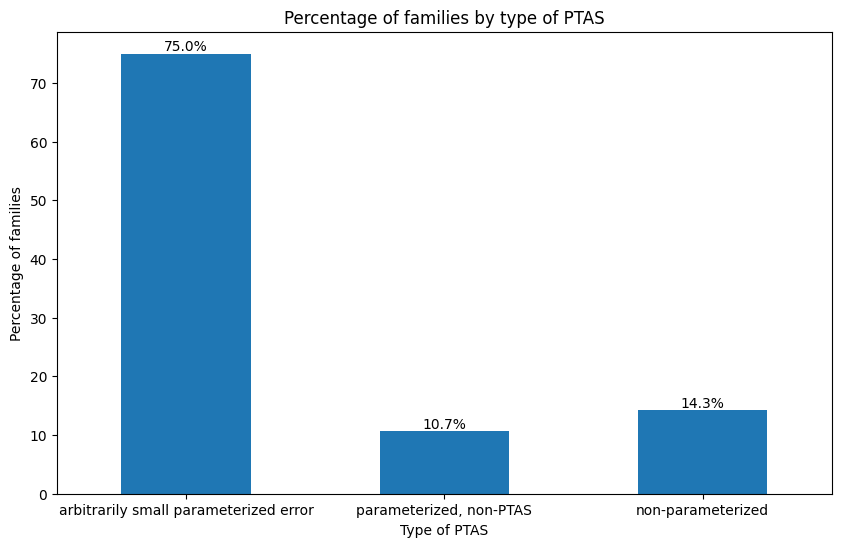

In [6]:
data = approximation_algorithms.copy()

# group by family, if at least one algorithm in the family is arbitrary small parameterized error, then the family is arbitrary small parameterized error
# if at least one algorithm in the family is parameterized, non-PTAS, then the family is parameterized, non-PTAS
# if at least one algorithm in the family is non-parameterized, then the family is non-parameterized

data['Type of PTAS (if PTAS)'] = data.groupby('Family Name')['Type of PTAS (if PTAS)'].transform(
    lambda x: 'arbitrarily small parameterized error' if 'arbitrarily small parameterized error' in x.values else (
        'parameterized, non-PTAS' if 'parameterized, non-PTAS' in x.values else 'non-parameterized')
)

data = data.drop_duplicates(subset=['Family Name', 'Type of PTAS (if PTAS)'])

# follow the order arbitrarily small parameterized error, parameterized, non-PTAS, non-parameterized
data['Type of PTAS (if PTAS)'] = pd.Categorical(
    data['Type of PTAS (if PTAS)'], categories=['arbitrarily small parameterized error', 'parameterized, non-PTAS', 'non-parameterized'], ordered=True)

# sort by type of PTAS
data.sort_values(by='Type of PTAS (if PTAS)', inplace=True)



# calculate percentage of families by type of PTAS
percentage = data.groupby('Type of PTAS (if PTAS)').size() / data['Family Name'].nunique() * 100

# plot percentage of families by type of PTAS
fig, ax = plt.subplots(figsize=(10, 6))
# bar plot
percentage.plot(kind='bar', ax=ax)

# add percentage values on top of bars
for i, v in enumerate(percentage):
    ax.text(i, v + 0.5, f'{v:.1f}%', ha='center')

# rotate x labels
plt.xticks(rotation=0)

plt.xlabel('Type of PTAS')
plt.ylabel('Percentage of families')

plt.title('Percentage of families by type of PTAS')

plt.show()

/var/folders/6k/rf2_mhpd7790drjk7smpzn2r0000gn/T/ipykernel_9770/1404496790.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  percentage = data.groupby(['Decade', 'Type of PTAS (if PTAS)']).size(


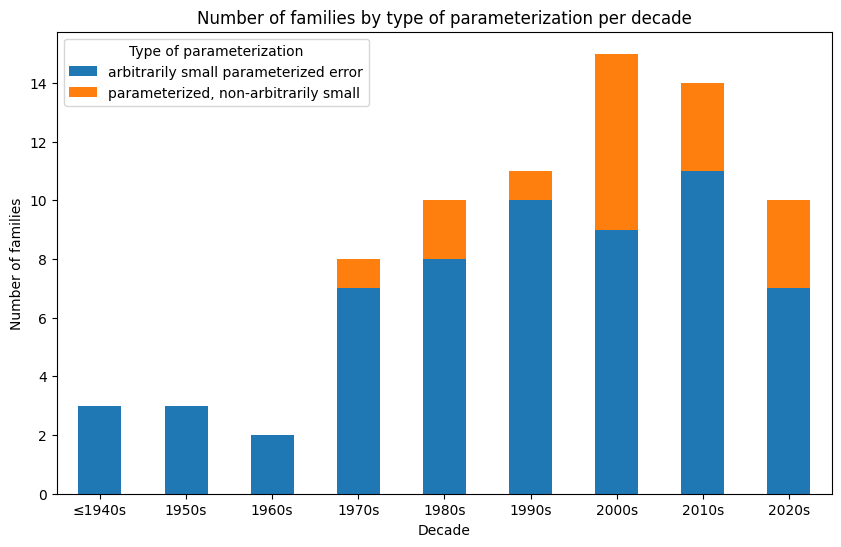

,Family Name,Looked at?,Relevant?,Variation,Algorithm Name,Year,Time Complexity Class,Approximation Factor Class (Mult),Approximation Factor Class (Add),Approximation Type (additive/multiplicative),Parametrized Approximation?,Type of PTAS (if PTAS),Parallel?,Quantum?,Decade
323,Root Computation,1,1,General Root Computation,False position method,1690,3,0,1.99,additive,yes,arbitrarily small parameterized error,0,0.0,1940
309,Discrete Fourier Transform,1,1,Nonequispaced Fourier Transform,"Dutt, Rohklin",1993,4,0,1.99,additive,yes,arbitrarily small parameterized error,0,0.0,1990
880,Determinant of Matrices with Integer Entries,1,1,Approximate Log-Determinant of Sparse Positive...,NaN,1999,4,0,1.99,additive,yes,arbitrarily small parameterized error,0,0.0,1990
254,Convex Optimization (Non-linear),1,1,Stochastic optimization,Dual subgradients and the drift-plus-penalty m...,1993,5,0,1.99,additive,yes,arbitrarily small parameterized error,0,0.0,1990
364,Nearest Neighbor Search,1,1,ANNS,Virtual Hypersphere Partitioning (VHP),2020,NaN,2,0.00,multiplicative,yes,arbitrarily small parameterized error,0,0.0,2020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,All-Pairs Shortest Paths (APSP),2,1,"Approximate Distance Oracle, weighted, undirec...",Wulff-Nilsen [Theorem 1],2012,5,4.5,0.00,multiplicative,yes,"parameterized, non-arbitrarily small",0,0.0,2010
299,Maximum-Weight Matching,1,1,"MWM, General (Approximate)","Pettie, Sanders",2004,5,2.5,0.00,multiplicative,yes,"parameterized, non-arbitrarily small",0,0.0,2000
1,Sorting,1,1,Approximate Sorting,NaN,2006,3,0,6.99,additive,yes,"parameterized, non-arbitrarily small",0,0.0,2000
192,LU Decomposition,1,1,Approximate Rectangular Matrix LU Decomposition,Randomized LU decomposition using sparse proje...,2016,4.5,0,5.00,additive,yes,"parameterized, non-arbitrarily small",0,0.0,2010


In [7]:
data = approximation_algorithms.copy()

# group by decade and family
data['Decade'] = data['Year'] // 10 * 10
# sort by decade
data.sort_values(by='Decade', inplace=True)

# merge decades <= 1930 into 1930
data.loc[data['Decade'] <= 1940, 'Decade'] = 1940

# group by decade and family
data['Type of PTAS (if PTAS)'] = data.groupby(['Decade', 'Family Name'])['Type of PTAS (if PTAS)'].transform(
    lambda x: 'arbitrarily small parameterized error' if 'arbitrarily small parameterized error' in x.values else (
        'parameterized, non-arbitrarily small' if 'parameterized, non-PTAS' in x.values else 'non-parameterized')
)

data = data.drop_duplicates(subset=['Decade', 'Family Name', 'Type of PTAS (if PTAS)'])


# remove non-parameterized families
data = data[data['Type of PTAS (if PTAS)'] != 'non-parameterized']

# follow the order arbitrarily small parameterized error, parameterized, non-PTAS, non-parameterized
data['Type of PTAS (if PTAS)'] = pd.Categorical(
    data['Type of PTAS (if PTAS)'], categories=['arbitrarily small parameterized error', 'parameterized, non-arbitrarily small'], ordered=True)

# sort by type of PTAS
data.sort_values(by='Type of PTAS (if PTAS)', inplace=True)

# plot percentage of families by type of PTAS per decade
fig, ax = plt.subplots(figsize=(10, 6))


# calculate percentage of families by type of PTAS per decade
percentage = data.groupby(['Decade', 'Type of PTAS (if PTAS)']).size(
) 

# unstack the data
percentage = percentage.unstack()

# bar plot
percentage.plot(kind='bar', stacked=True, ax=ax)

# rotate x labels
plt.xticks(rotation=0)

# first x label to ≤1940s
labels = [item.get_text() + 's' for item in ax.get_xticklabels()]
labels[0] = '≤1940s'
ax.set_xticklabels(labels)

plt.legend(title='Type of parameterization')

plt.xlabel('Decade')
plt.ylabel('Number of families')
plt.title('Number of families by type of parameterization per decade')
plt.show()

data